In [1]:
import pandas as pd , numpy as np , seaborn as sns , matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
from torch.utils.data import Dataset , DataLoader

In [4]:
from sklearn.preprocessing import StandardScaler , LabelEncoder
from sklearn.model_selection import train_test_split

In [5]:
%%matplotlib.inline

UsageError: Cell magic `%%matplotlib.inline` not found.


In [6]:
try:
    df = pd.read_csv('/content/synthetic_financial_data_bukharii.csv')
except FileNotFoundError as e:
  print(f'{e}')

In [19]:
def fin_data():
  for col in df.columns: print(f'{col}: {df[col].isnull().sum()}')
fin_data()

company_id: 0
date: 0
industry: 0
region: 0
company_size: 0
customer_tenure: 0
revenue: 0
cost_of_goods_sold: 0
operating_income: 0
total_assets: 0
total_debt: 0
revenue_growth: 0
risk_score: 0
churn: 0
gross_profit: 0
operating_margin: 0
debt_ratio: 0
log_revenue: 0
some_other_features: 0


In [10]:
for col in df.columns: print(f'{col}')

company_id
date
industry
region
company_size
customer_tenure
revenue
cost_of_goods_sold
operating_income
total_assets
total_debt
revenue_growth
risk_score
churn
gross_profit
operating_margin
debt_ratio
log_revenue
some_other_features


In [8]:
df = df.dropna(subset=['revenue' , 'risk_score' , 'churn'])

In [9]:
cate_cols = ['industry' , 'region' , 'company_size']

In [10]:
encoders = {col: LabelEncoder().fit(df[col]) for col in cate_cols}

In [11]:
for col in cate_cols:
  df[col] = encoders[col].transform(df[col])

In [12]:
features: list = ['customer_tenure' , 'industry' , 'some_other_features' , 'company_size' , 'region' , 'operating_margin' , 'debt_ratio' , 'log_revenue' , 'gross_profit']

In [13]:
X = df[features].values

In [14]:
target_col: list = ['revenue_growth' , 'risk_score' , 'churn']

In [15]:
scaler = StandardScaler()

In [16]:
X = scaler.fit_transform(X)

In [17]:
y = df[target_col].values

In [20]:
y_risk_score , y_revenue_growth , y_churn = df['risk_score'] , df['revenue_growth'] , df['churn']

In [21]:
X_train , X_val , y_train , y_val = train_test_split(X , y , test_size=0.2 , random_state=42)

In [22]:
class FinanceDataset(Dataset):
  def __init__(self , X , y): self.X , self.y = torch.tensor(X, dtype=torch.float32) , torch.tensor(y , dtype=torch.float32)

  def __len__(self): return len(self.X)

  def __getitem__(self, idx): return self.X[idx] , self.y[idx]

In [24]:
batch_size , train_ds , val_ds = 128 , FinanceDataset(X_train , y_train) , FinanceDataset(X_val , y_val)

In [25]:
train_loader , val_loader = DataLoader(train_ds ,  shuffle=True , batch_size=batch_size) , DataLoader(val_ds , batch_size=batch_size)

In [26]:
import torch.nn as nn

In [46]:
class finance_model(nn.Module):
  def __init__(self , input_dim):
    super(finance_model , self).__init__()

    self.shared = nn.Sequential(
        nn.Linear(input_dim , 128),
        nn.ReLU(),
        nn.BatchNorm1d(128),
        nn.Dropout(0.3),
        nn.Linear(128 , 64),
        nn.ReLU()
    )

    self.revenue_head , self.risk_head , self.churn_head = nn.Linear(64 , 1) , nn.Linear(64 , 1) , nn.Linear(64 , 1)

  def forward(self , X):

    X = self.shared(X)

    revenue= self.revenue_head(X)
    risk=self.risk_head(X)
    churn= (self.churn_head(X))

    return revenue.squeeze () , risk.squeeze() , churn.squeeze()

In [47]:
model = finance_model(input_dim=X.shape[1])

In [48]:
optimizer = torch.optim.Adam(model.parameters() , lr=0.00005)
loss_fn1 = nn.MSELoss()
loss_fn2 = nn.BCEWithLogitsLoss()

In [49]:
device = torch.device('cpu')

In [50]:
model.to(device)

finance_model(
  (shared): Sequential(
    (0): Linear(in_features=9, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
  )
  (revenue_head): Linear(in_features=64, out_features=1, bias=True)
  (risk_head): Linear(in_features=64, out_features=1, bias=True)
  (churn_head): Linear(in_features=64, out_features=1, bias=True)
)

In [51]:
epochs: int= 80

losses : list = []

val_losses : list = []

In [52]:
def validation(model , loss_fn1 , loss_fn2 , device, val_loader):

  model.eval()
  val_loss = 0.0

  with torch.no_grad():
    for X_batch , y_batch in val_loader:
      X_batch , y_batch = X_batch.to(device) , y_batch.to(device)
      y_rev , y_risk , y_churn = y_batch[: , 0] , y_batch[: , 1] , y_batch[: , 2]

      (pred_rev , pred_risk , pred_churn) = model(X_batch)

      loss_rev , loss_risk , loss_churn = loss_fn1(pred_rev , y_rev) , loss_fn1(pred_risk , y_risk) , loss_fn2(pred_churn , y_churn)

      loss = loss_rev + loss_risk + loss_churn

      val_loss += loss.item()

    return val_loss / len(val_loader)

In [53]:
epochs : int = 100
losses : list[float] = []
var_losses : list[float] = []

In [56]:
for epoch in range(epochs):
  model.train()

  runing_loss = 0.0

  for X_batch , y_batch in train_loader :
    X_batch , y_batch = X_batch.to(device) , y_batch.to(device)
    y_rev , y_risk , y_churn = y_batch[: , 0] , y_batch[: , 1] , y_batch[: , 2]

    optimizer.zero_grad()

    pred_rev , pred_risk , pred_churn = model(X_batch)

    loss_rev = loss_fn1( pred_rev , y_rev)
    loss_risk = loss_fn1 (pred_risk , y_risk )
    loss_churn = loss_fn2 (pred_churn , y_churn)

    loss = loss_rev + loss_risk + loss_churn

    loss.backward()

    optimizer.step()

    runing_loss += loss.item()

  trian_loss_avg = runing_loss / len(train_loader)
  losses.append(trian_loss_avg)

  if (epoch + 1) % 5 == 0:
    val_loss = validation(model , loss_fn1 , loss_fn2 , device, val_loader)
    val_losses.append(val_loss)
    print(f'Epoch: {epoch + 1}/{epochs} -> Training Loss: {trian_loss_avg:.4f} | Val Loss: {val_loss:.4f}')

  else: print(f'Epoch {epoch+1}/{epoch} -> Training Loss: {trian_loss_avg:.4f}')

Epoch 1/0 -> Training Loss: 0.6301
Epoch 2/1 -> Training Loss: 0.6297
Epoch 3/2 -> Training Loss: 0.6307
Epoch 4/3 -> Training Loss: 0.6300
Epoch: 5/100 -> Training Loss: 0.6300 | Val Loss: 0.6354
Epoch 6/5 -> Training Loss: 0.6294
Epoch 7/6 -> Training Loss: 0.6295
Epoch 8/7 -> Training Loss: 0.6300
Epoch 9/8 -> Training Loss: 0.6296
Epoch: 10/100 -> Training Loss: 0.6291 | Val Loss: 0.6347
Epoch 11/10 -> Training Loss: 0.6294
Epoch 12/11 -> Training Loss: 0.6295
Epoch 13/12 -> Training Loss: 0.6297
Epoch 14/13 -> Training Loss: 0.6286
Epoch: 15/100 -> Training Loss: 0.6293 | Val Loss: 0.6361
Epoch 16/15 -> Training Loss: 0.6278
Epoch 17/16 -> Training Loss: 0.6282
Epoch 18/17 -> Training Loss: 0.6281
Epoch 19/18 -> Training Loss: 0.6280
Epoch: 20/100 -> Training Loss: 0.6281 | Val Loss: 0.6350
Epoch 21/20 -> Training Loss: 0.6280
Epoch 22/21 -> Training Loss: 0.6279
Epoch 23/22 -> Training Loss: 0.6276
Epoch 24/23 -> Training Loss: 0.6279
Epoch: 25/100 -> Training Loss: 0.6277 | Val 

In [57]:
import matplotlib.pyplot as plt

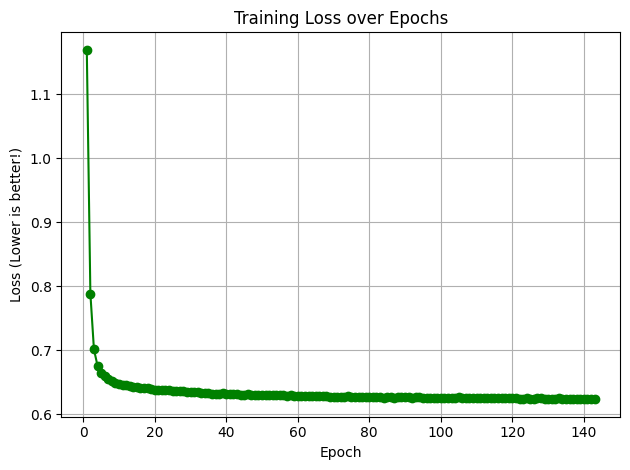

In [58]:
plt.plot(range(1, len(losses) + 1) , losses , marker = 'o' , color='green')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (Lower is better!)')
plt.grid()
plt.tight_layout()
plt.show()

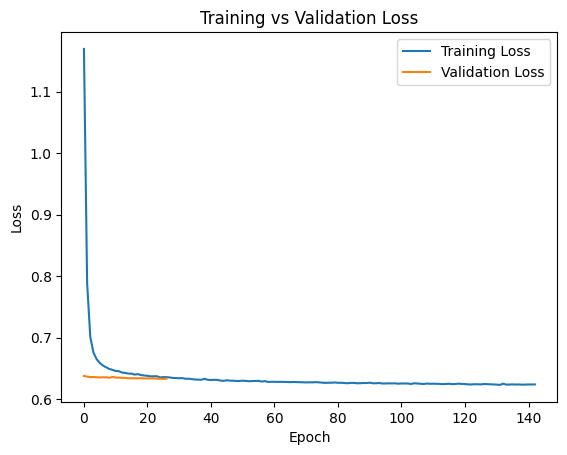

In [59]:
import matplotlib.pyplot as plt

plt.plot(losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


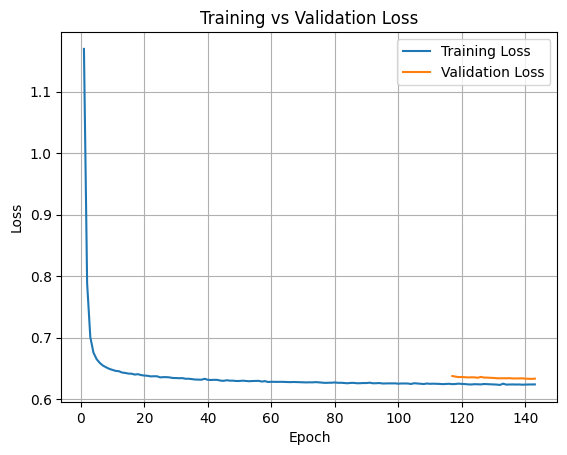

In [60]:
import matplotlib.pyplot as plt

# Plot training loss for all epochs
epochs_range = range(1, len(losses) + 1)
plt.plot(epochs_range, losses, label="Training Loss")

# Match validation epochs range dynamically
val_epochs_range = range(len(losses) - len(val_losses) + 1, len(losses) + 1)
plt.plot(val_epochs_range, val_losses, label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.show()
